Draft (20 Points)

Jupyter Notebook (both .PDF and .ipynb files)

You need to use the report template and fill out the following sections, each of which we will score based on the clarity and appropriateness of your writing (percentage of total grade for each component shown). All the information must be in the Jupyter notebook.



*   Introduction (2): A clear, high-level description of what the original paper is about and what is the contribution of it

*   Scope of reproducibility (2)
*   Methodology (8)
    *  Data
        *   Data Descriptions
        *  Implementation Code
    *  Model
      * Model descriptions
      *  Implementation Code
    *   Training
        *   Computational requirements
        *   Implementation code
    *   Evaluation
        *   Metrics descriptions
        *   Implementation code

*   Results (8)
  *   Results
  *   Analyses
  *  Plans









# Introduction

The paper "Deep Learning Enables Accurate Diagnosis of Novel Coronavirus (COVID-19) With CT Images" [1] focuses on leveraging deep learning technologies to automate the COVID-19 diagnostic process, reduce subjectivity in human interpretation, and enhance the accuracy of diagnosing COVID-19 from computed tomography (CT) images. This research is pivotal given the urgent global need for efficient diagnostic methods to combat the spread of COVID-19, which overwhelmed traditional healthcare systems at its peak.

The paper introduces the development of a new DRENet model which leverages the attention mechanism. This model is designed to meticulously focus on the most relevant features of lung CT images that indicate the presence of COVID-19, effectively distinguishing it from other types of viral pneumonia. Through this, DRENet can selectively enhance the diagnostic features while suppressing irrelevant background information, resulting in more accurate and robust predictions.

The performance of the DRENet model is demonstrated through validations on a dataset of lung CT images from multiple hospitals. The results showcased improved performance over traditional diagnostic methods, but a deficiency in generalizing to other hospital data which the authors refer to as the "batch effect", which is mostly due to the limited training set size the model was trained on [1].

# Scope of Reproducibility

Firstly, we will be replicating the results necessitates with access to the same dataset utilized in the paper. Secondly, we will be applying modified pre-processing using U-Net. This includes details on resizing, normalization, and segmentation techniques. Lastly, we will be modifying parameters such as learning rate, batch size, optimizer, and epochs to get the evaluation impact by different metrics such as accuracy, recall, F1 score, and sensitivity. Moreover, understanding that compute power is a constraint, we have tuned hyperparameters accordingly. Following all this, we will ensure the replicability of their findings, enabling validation and advancement by the scientific community.

<br>

**Hypotheses to Test:**

1. Hypothesis 1: The model achieves a recall of 0.93 and precision of 0.86 for discriminating COVID-19 (non-bacterial pneumonia) patients from other patients.
2. Hypothesis 2: The model extracts main lesion features, especially the ground-glass opacity (GGO), which are visually helpful for assisted diagnoses by doctors.
3. Hypothesis 3: The model is not strongly extensible to other hospital data.

# Methodology

### Environment

We transferred the code available as part of the paper in the GitHub repository to a Google Colab notebook running on Python 3. After seeing that the available memory was maxing out after we were running the training script as a part of reproducing the paper's results, we decided to upgrade to Google Colab Pro and used a High-RAM environment, which provided us 51 GB of total RAM, enough to handle our workload. We trained our model on a Tensor Processing Unit (TPU) as we expected that the training process (both forward and backpropagation) would be executed more efficiently.

## Data

### Data Source

The data we used to train our model was the data source curated and used by the paper authors [1]. To test Hypothesis 3 above to determine whether our model can generalize to other hospital patient data, we tested our model's performance on additional data we collected, which are lung CT scan lung images data from patients in hospitals from Sao Paulo, Brazil [2].

### Data Process

We will import and use the COVID-19 lung CT scan data that was used to train the model in the paper.  This data was already available in the paper's GitHub repository [1], and has already been divided into train, validation, and test sets. Each of them is stored in an individual directory, and has two sub-directories, representing the two classes (COVID positive and COVID negative images). This allows PyTorch to determine the class label for the images.


In [ ]:
!unzip local_traniner.zip

Archive:  local_traniner.zip
replace __MACOSX/._local_traniner? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
import scipy.misc
import os
import sys
import time
import logging
from PIL import Image
from torchvision import transforms
import torch
from tqdm import tqdm
from scipy import ndimage as ndi
from scipy.io import loadmat
from __future__ import print_function
import random
import matplotlib.pyplot as plt
import torch.utils.data
import torch
from torch import nn
import torch.nn as nn
from torch.nn import DataParallel
from torch.nn import functional as F
import torchvision.models as models
from torchvision import models
from torch.hub import load_state_dict_from_url
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import roc_auc_score
import pickle
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, \
    reconstruction, binary_closing
from skimage.measure import label, regionprops
from skimage.filters import roberts
from skimage.segmentation import clear_border
import cv2
import glob
import shutil
from tqdm import tqdm
from numba import jit
import math
import torch.utils.model_zoo as model_zoo
from operator import xor

Below, we define common constants and functions that will be used throughout our notebook.

In [ ]:
BATCH_SIZE = 25
PROPOSAL_NUM = 6
CAT_NUM = 6
INPUT_SIZE = (448, 448) # (image width, image height)
LR = 0.0008
WD = 1e-4
SAVE_FREQ = 1
TOTAL_BAR_LENGTH = 40
TERM_WIDTH = 50
resume = '' #'./20200223_152850/002.ckpt'
test_model = 'model.ckpt'
save_dir = './'
input_train_path = 'local_traniner/input/train/'
train_path = 'local_traniner/input/train'
val_path = 'local_traniner/input/val'
test_path = 'local_traniner/input/test'
new_hospital_test_path = 'local_traniner/input/testNewHospital'
processed_input_train_path = 'local_traniner/input/trainProcessed'
processed_segmented_input_train_path = 'local_traniner/input/trainProcessedSegmented'

_default_anchors_setting_small = (
    dict(layer='p3', stride=32, size=48, scale=[1], aspect_ratio=[1]),
    dict(layer='p4', stride=64, size=96, scale=[1], aspect_ratio=[1]),
)
_default_anchors_setting_large = (
    dict(layer='p5', stride=128, size=192, scale=[1], aspect_ratio=[1]),
)


def listdir_nohidden(path):
    return glob.glob(os.path.join(path, '*'))


last_time = time.time()
begin_time = last_time

def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()

    cur_len = int(TOTAL_BAR_LENGTH * current / total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    print(TERM_WIDTH - int(TOTAL_BAR_LENGTH) - len(msg) - 3)
    for i in range(TERM_WIDTH - int(TOTAL_BAR_LENGTH) - len(msg) - 3):
        sys.stdout.write(' ')

    for i in range(TERM_WIDTH - int(TOTAL_BAR_LENGTH / 2)):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current + 1, total))

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


def format_time(seconds):
    days = int(seconds / 3600 / 24)
    seconds = seconds - days * 3600 * 24
    hours = int(seconds / 3600)
    seconds = seconds - hours * 3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes * 60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds * 1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

### Image Anchor Setup

The following code block generates the anchor maps which is used by the DRENet model. The code defines two anchor box configurations (small and large), each with a specific scale and aspect ratio. Through this, the DRENet model is able to extract spatial information at different scales of the image, enabling it to process the entire image.

In [ ]:
def generate_default_anchor_maps(anchors_setting=None, input_shape=INPUT_SIZE,
                                 setting='small'):
    """
    generate default anchor

    :param anchors_setting: all informations of anchors
    :param input_shape: shape of input images, e.g. (h, w)
    :return: center_anchors: # anchors * 4 (oy, ox, h, w)
             edge_anchors: # anchors * 4 (y0, x0, y1, x1)
             anchor_area: # anchors * 1 (area)
    """
    if anchors_setting is None:
        if setting == 'small':
            anchors_setting = _default_anchors_setting_small
        else:
            anchors_setting = _default_anchors_setting_large

    center_anchors = np.zeros((0, 4), dtype=np.float32)
    edge_anchors = np.zeros((0, 4), dtype=np.float32)
    anchor_areas = np.zeros((0,), dtype=np.float32)
    input_shape = np.array(input_shape, dtype=int)

    for anchor_info in anchors_setting:

        stride = anchor_info['stride']
        size = anchor_info['size']
        scales = anchor_info['scale']
        aspect_ratios = anchor_info['aspect_ratio']

        output_map_shape = np.ceil(input_shape.astype(np.float32) / stride)
        output_map_shape = output_map_shape.astype(np.int16)
        output_shape = tuple(output_map_shape) + (4,)
        ostart = stride / 2.
        oy = np.arange(ostart, ostart + stride * output_shape[0], stride)
        oy = oy.reshape(output_shape[0], 1)
        ox = np.arange(ostart, ostart + stride * output_shape[1], stride)
        ox = ox.reshape(1, output_shape[1])
        center_anchor_map_template = np.zeros(output_shape, dtype=np.float32)
        center_anchor_map_template[:, :, 0] = oy
        center_anchor_map_template[:, :, 1] = ox
        for scale in scales:
            for aspect_ratio in aspect_ratios:
                center_anchor_map = center_anchor_map_template.copy()
                center_anchor_map[:, :, 2] = size * scale / float(aspect_ratio) ** 0.5
                center_anchor_map[:, :, 3] = size * scale * float(aspect_ratio) ** 0.5

                edge_anchor_map = np.concatenate((center_anchor_map[..., :2] - center_anchor_map[..., 2:4] / 2.,
                                                  center_anchor_map[..., :2] + center_anchor_map[..., 2:4] / 2.),
                                                 axis=-1)
                anchor_area_map = center_anchor_map[..., 2] * center_anchor_map[..., 3]
                center_anchors = np.concatenate((center_anchors, center_anchor_map.reshape(-1, 4)))
                edge_anchors = np.concatenate((edge_anchors, edge_anchor_map.reshape(-1, 4)))
                anchor_areas = np.concatenate((anchor_areas, anchor_area_map.reshape(-1)))

    return center_anchors, edge_anchors, anchor_areas


def hard_nms(cdds, topn=10, iou_thresh=0.25):
    if not (type(cdds).__module__ == 'numpy' and len(cdds.shape) == 2 and cdds.shape[1] >= 5):
        raise TypeError('edge_box_map should be N * 5+ ndarray')

    cdds = cdds.copy()
    indices = np.argsort(cdds[:, 0])
    cdds = cdds[indices]
    cdd_results = []

    res = cdds

    while res.any():
        cdd = res[-1]
        cdd_results.append(cdd)
        if len(cdd_results) == topn:
            return np.array(cdd_results)
        res = res[:-1]

        start_max = np.maximum(res[:, 1:3], cdd[1:3])
        end_min = np.minimum(res[:, 3:5], cdd[3:5])
        lengths = end_min - start_max
        intersec_map = lengths[:, 0] * lengths[:, 1]
        intersec_map[np.logical_or(lengths[:, 0] < 0, lengths[:, 1] < 0)] = 0
        iou_map_cur = intersec_map / ((res[:, 3] - res[:, 1]) * (res[:, 4] - res[:, 2]) + (cdd[3] - cdd[1]) * (
            cdd[4] - cdd[2]) - intersec_map)
        res = res[iou_map_cur <= iou_thresh]

    return np.array(cdd_results)


def cdds2attention_map(top_n_cdds):
    attention_box_lst = []
    attention_map_lst = []
    c = 600/448
    for i in range(len(top_n_cdds)):
        att_map = np.zeros((448, 448))
        MIN_y = 448
        MAX_y = 0
        MIN_x = 448
        MAX_x = 0
        SUM = top_n_cdds[i][:, 0].sum()
        for j in range(3):
            [y0, x0, y1, x1] = top_n_cdds[i][j, 1:5].astype(np.int16)
            y0, x0, y1, x1 = get_xy(y0, x0, y1, x1)
            y0 = y0 - 224
            x0 = x0 - 224
            y1 = y1 - 224
            x1 = x1 - 224
            if MIN_y > y0:
                MIN_y = y0
            if MAX_y < y1:
                MAX_y = y1
            if MIN_x > x0:
                MIN_x = x0
            if MAX_x < x1:
                MAX_x = x1
            att_map[y0:y1, x0:x1] += top_n_cdds[i][j][0] / SUM
        attention_box_lst.append(
                [np.int16(MIN_y*c), np.int16(MIN_x*c),
                 np.int16(MAX_y*c), np.int16(MAX_x*c)])
        attention_map_lst.append(att_map)
    return attention_box_lst, attention_map_lst


def get_xy(y0, x0, y1, x1, size=448):
    pad_size = size//2

    y0 = np.max([y0, pad_size])
    y0 = np.min([y0, size+pad_size])

    x0 = np.max([x0, pad_size])
    x0 = np.min([x0, size+pad_size])

    y1 = np.max([y1, pad_size])
    y1 = np.min([y1, size+pad_size])

    x1 = np.max([x1, pad_size])
    x1 = np.min([x1, size+pad_size])

    return y0, x0, y1, x1



if __name__ == '__main__':
    a = hard_nms(np.array([
        [0.4, 1, 10, 12, 20],
        [0.5, 1, 11, 11, 20],
        [0.55, 20, 30, 40, 50]
    ]), topn=100, iou_thresh=0.4)
    print(a)

[[ 0.55 20.   30.   40.   50.  ]
 [ 0.5   1.   11.   11.   20.  ]]


### Load COVID-19 Patient Lung Image Dataset

Below, we define a class named SARS which will contain generic functions for data fetching and visualization. We will scan all patient data from the COVID and no-COVID subdirectories of the train/val/test directory. There are a total of 2,863 images in the primary dataset we will be using to reproduce the paper's results. There images are divided into training, validation, and test sets as follows: the training set and validation set each comprises of 40% of the total data (1,148 images each) and the test set comprises of the remaining 20% (567 images) of the total data.

The new lung CT scan data we curated to test Hypothesis 3 (the extensibility of the model), is comprised of a total of 2,481 images, divided into 1,252 COVID positive and 1,229 COVID negative images. Note that these images are not used for training, but are rather used to test our trained model.

In [ ]:
random.seed(0)

def clean_name(name):
    return name
    name = name.replace(' ', '').replace('.jpg', '')
    try:
        int(name)
        return name
    except:
        pass
    while True:
        try:
            int(name[-1])
            name = name[:-1]
        except:
            return name

class SARS():
    def __init__(self, root, is_train=True):
        self.is_train = is_train

        path = f'{root}/no_nCoV'
        self.file_lst = [f'{path}/{item}' for item in os.listdir(path)]
        self.people_lst = [clean_name(item.split('_')[0])
                            for item in os.listdir(path)]
        self.label_lst = [0]*len(os.listdir(path))

        path = f'{root}/nCoV'
        self.file_lst += [f'{path}/{item}' for item in os.listdir(path)]
        self.people_lst += [clean_name(item.split('_')[0])
                            for item in os.listdir(path)]
        self.label_lst += [1]*len(os.listdir(path))

        temp = list(zip(self.file_lst, self.label_lst, self.people_lst))
        random.shuffle(temp)
        self.file_lst = [item[0] for item in temp]
        self.label_lst = [item[1] for item in temp]
        self.people_lst = [item[2] for item in temp]
        self.file_name = [item.split('/')[-1] for item in self.file_lst]

    def __getitem__(self, index):
        flg_H = 0
        img = np.array(Image.open(self.file_lst[index]))
        target = self.label_lst[index]
        if len(img.shape) == 2:
            img = np.stack([img] * 3, 2)
        img_raw = img.copy()
        img = Image.fromarray(img, mode='RGB')
        img = transforms.Resize((448, 448), Image.BILINEAR)(img)
        if self.is_train:
            img = transforms.RandomCrop(INPUT_SIZE)(img)
            if np.random.randint(2) == 1:
                flg_H = 1
                img = transforms.RandomHorizontalFlip(p=1)(img)
            img = transforms.ColorJitter(brightness=0.126, saturation=0.5)(img)
        else:
            img = transforms.CenterCrop(INPUT_SIZE)(img)
            pass
        img = transforms.ToTensor()(img)
        img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        img_raw = Image.fromarray(img_raw, mode='RGB')
        img_raw = transforms.Resize((600, 600), Image.BILINEAR)(img_raw)
        if flg_H == 1:
            img_raw = transforms.RandomHorizontalFlip(p=1)(img_raw)

        img_raw = transforms.ToTensor()(img_raw)
        img_raw = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img_raw)
        return img, target, img_raw, self.people_lst[index], self.file_name[index]

    def __len__(self):
        return len(self.label_lst)

    @staticmethod
    def plot_images(images, titles, numCols):
        """plot a list of images in a grid"""
        numRows = int(np.ceil(len(images) / numCols))
        plt.figure(figsize=(15, 10))
        for idx, (image, title) in enumerate(zip(images, titles)):
            plt.subplot(numRows, numCols, idx+1)
            image = image.permute(1, 2, 0).numpy()
            image = (image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))
            plt.imshow(image)
            plt.title(title)
            plt.axis('off')

        plt.show()

### Exploratory Data Analysis (EDA)


Below, we visualize 8 sample lung CT scan training images, as well as 8 images for COVID patients and 8 images for non-COVID patients.

In [ ]:
if __name__ == '__main__':
    train_set, val_set, test_set  = SARS(train_path), SARS(val_path), SARS(test_path)
    print('# SARS Training Images: ', len(train_set.file_lst))
    print('# SARS Validation Images: ', len(val_set.file_lst))
    print('# SARS Test Images: ', len(test_set.file_lst))

    # plot general lung images
    images, labels = [], []
    for i in range(8):
        img, target, img_raw, _, _ = train_set[i]
        images.append(img)
        labels.append(f'Sample #{i+1}')
    train_set.plot_images(images=images, titles=labels, numCols=4)

    # plot COVID negative sample lung images
    no_nCoV_images, no_nCoV_labels = [], []
    no_nCoV_path = 'local_traniner/input/train/no_nCoV'
    print('# COVID Negative Training Images:', len(os.listdir(no_nCoV_path)))
    for i in range(8):
        img_path = os.path.join(no_nCoV_path, random.choice(os.listdir(no_nCoV_path)))
        img = Image.open(img_path)
        img = transforms.Resize((448, 448), Image.BILINEAR)(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        no_nCoV_images.append(img)
        no_nCoV_labels.append(f'no_nCoV Sample #{i+1}')
    train_set.plot_images(images=no_nCoV_images, titles=no_nCoV_labels, numCols=4)

    # plot COVID positive sample lung images
    nCoV_images, nCoV_labels = [], []
    nCoV_path = 'local_traniner/input/train/nCoV'
    print('# COVID Positive Training Images:', len(os.listdir(nCoV_path)))
    for i in range(8):
        img_path = os.path.join(nCoV_path, random.choice(os.listdir(nCoV_path)))
        img = Image.open(img_path)
        img = transforms.Resize((448, 448), Image.BILINEAR)(img)
        img = transforms.ToTensor()(img)
        img = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(img)
        nCoV_images.append(img)
        nCoV_labels.append(f'nCoV Sample #{i+1}')
    train_set.plot_images(images=nCoV_images, titles=nCoV_labels, numCols=4)

# SARS Training Images:  24
# SARS Validation Images:  12
# SARS Test Images:  19


UnidentifiedImageError: cannot identify image file 'local_traniner/input/train/nCoV/.DS_Store'

In [ ]:
def plot_histogram(images, num_bins=256):
    """Plot histograms for a set of images"""
    plt.figure(figsize=(10, 8))
    for i, img in enumerate(images):
        plt.subplot(len(images), 1, i+1)
        plt.hist(img.ravel(), bins=num_bins, range=(0, 5), color='blue', alpha=0.7)
        plt.title(f'Histogram of image {i+1}')
        plt.xlabel('Pixel Intensity')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

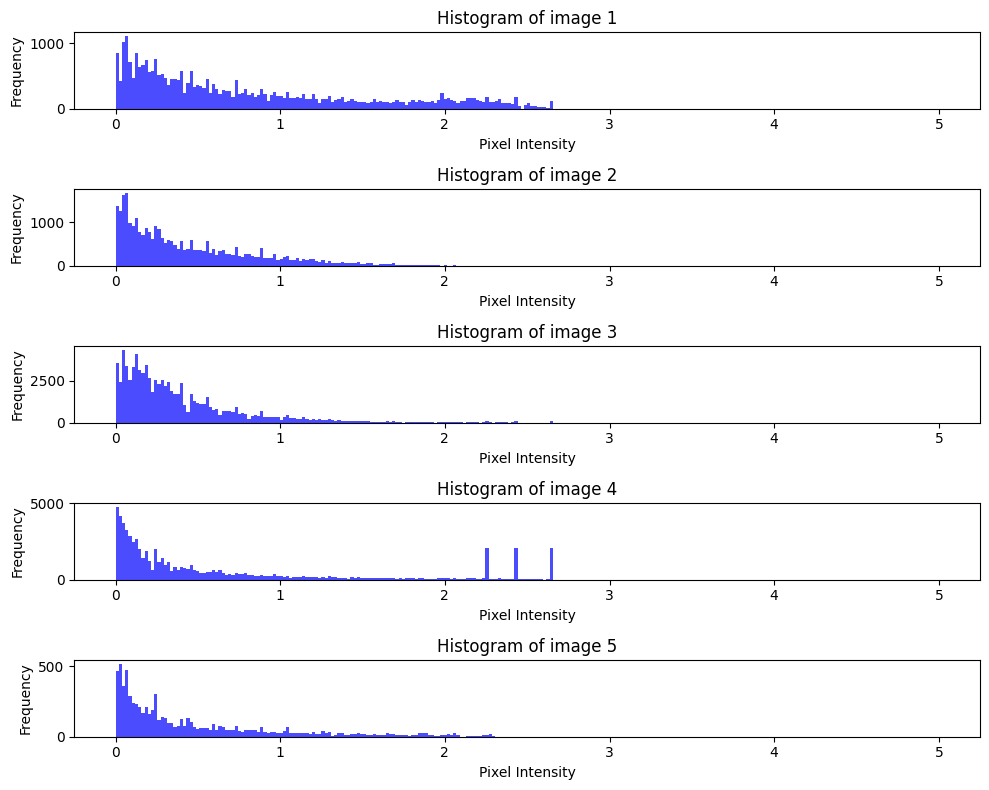

In [ ]:
if __name__ == '__main__':
    dataset = SARS(train_path)
    sample_indices = random.sample(range(len(dataset)), 5)
    sample_images = [dataset[i][0] for i in sample_indices]
    plot_histogram(sample_images)

### Data Preprocessing

In [ ]:
def get_segmented_lungs(img_dir, plot=False, min_lung_area=3000, padding_num=0):
    """
    :param img_dir: Input image path
    :param plot: Whether to show pictures or not
    :param min_lung_area: The minimum possible area of a lung (as a threshold)
    :param padding_num: Interception needs padding size
    :return: True or False (img is useful or not)
    """

    src_img = cv2.imread(img_dir)
    img = Image.open(img_dir)
    img = np.array(img)[:, :, 0]
    img = img.astype(np.int16)
    img = img * 3
    img -= 1000
    im = img.copy()
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image.
    '''
    binary = im < -600
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone)
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone)
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone)
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2] or region.area < min_lung_area:
                for coordinates in region.coords:
                    label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone)
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone)
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone)
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone)
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone)
    mask = binary.astype(int)

    mask_img = np.zeros(src_img.shape, dtype=src_img.dtype)
    mask_img[mask == 1] = [255, 255, 0]

    if plot == True:
        plt.figure(figsize=(12, 12))
        plt.imshow(mask_img)
        plt.show()

    if mask_img.mean() < 7:
        return (False, [], [], [])
    else:

        # find the smallest effective rectangle surrounding the lungs
        gray = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)
        ret, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        label_img = np.zeros(src_img.shape)
        cv2.drawContours(label_img, contours, -1, (255, 255, 0), thickness=cv2.FILLED)

        minx, miny, maxx, maxy = src_img.shape[1], src_img.shape[0], 0, 0
        for c in contours:
            if cv2.contourArea(c) > min_lung_area:
                temp_minx = np.min(c[:, 0, 0])
                temp_miny = np.min(c[:, 0, 1])
                temp_maxx = np.max(c[:, 0, 0])
                temp_maxy = np.max(c[:, 0, 1])
                if temp_minx < minx:
                    minx = temp_minx
                if temp_miny < miny:
                    miny = temp_miny
                if temp_maxx > maxx:
                    maxx = temp_maxx
                if temp_maxy > maxy:
                    maxy = temp_maxy
        crop_img = src_img[miny - padding_num:maxy + padding_num, minx - padding_num:maxx + padding_num]
        crop_mask = mask[miny - padding_num:maxy + padding_num, minx - padding_num:maxx + padding_num]
        crop_copy = crop_img.copy()
        crop_img[crop_mask == 0] = [0, 0 , 0]

        if plot == True:
            plt.figure(figsize=(9, 9))
            plt.imshow(crop_img, cmap='gray')
            plt.show()

        # fill crop area
        crop_mask = np.stack([crop_mask] * 3, 2)
        background = entity_filling(crop_img, crop_mask)

        filled_crop_img = np.where(crop_mask == 1, crop_img, background)
        filled_crop_img = np.array(filled_crop_img, dtype=np.int16)

        return (True, filled_crop_img, crop_img, crop_copy)


@jit(nopython=True)
def entity_filling(src_img, mask):
    background = np.zeros_like(src_img)
    for i in range(40):
        ix = np.random.randint(0, src_img.shape[0])
        if np.random.randint(2) == 0:
            label_img = np.concatenate(
                [np.zeros((src_img.shape[0] - ix, src_img.shape[1], 3)), src_img[:ix, :]], 0)
            new_mask = np.concatenate(
                [np.zeros((src_img.shape[0] - ix, src_img.shape[1], 3)), mask[:ix, :]], 0)
        else:
            label_img = np.concatenate(
                [src_img[ix:, :], np.zeros((ix, src_img.shape[1], 3))], 0)
            new_mask = np.concatenate(
                [mask[ix:, :], np.zeros((ix, src_img.shape[1], 3))], 0)
        ix = np.random.randint(0, src_img.shape[1])
        if np.random.randint(2) == 0:
            label_img = np.concatenate(
                [np.zeros((src_img.shape[0], src_img.shape[1] - ix, 3)), label_img[:, :ix]], 1)
            new_mask = np.concatenate(
                [np.zeros((src_img.shape[0], src_img.shape[1] - ix, 3)), new_mask[:, :ix]], 1)
        else:
            label_img = np.concatenate(
                [label_img[:, ix:], np.zeros((src_img.shape[0], ix, 3))], 1)
            new_mask = np.concatenate(
                [new_mask[:, ix:], np.zeros((src_img.shape[0], ix, 3))], 1)

        background = np.where(new_mask == 1, label_img, background)
    return background


def make_save(save_path):
    source_dir = os.path.join(save_path, 'source')
    os.makedirs(source_dir, exist_ok=True)
    crop_dir = os.path.join(save_path, 'source_crop')
    os.makedirs(crop_dir, exist_ok=True)
    process_dir = os.path.join(save_path, 'filled')
    os.makedirs(process_dir, exist_ok=True)
    src_crop_dir = os.path.join(save_path, 'crop')
    os.makedirs(src_crop_dir, exist_ok=True)
    return source_dir, crop_dir, process_dir, src_crop_dir


def choose_img(img_list_len, choose_nums=15):
    if img_list_len <= 0:
        return None
    else:
        if img_list_len < 10:
            return np.arange(0, img_list_len)
        elif int(0.5 * img_list_len) < choose_nums:
            choose_nums = int(0.5 * img_list_len)
        return np.arange(int(0.25 * img_list_len), int(0.75 * img_list_len), int(0.5 * img_list_len / choose_nums))


@jit(nopython=True)
def normalize(img_dirs, sp1, sp2, sp3, crop_imgs, filled_imgs):
    if sp1!= []:
        images = []
        for item in img_dirs:
            images.append(cv2.imread(item))
        images = np.array(images)
        mean = np.mean(images)
        var = np.mean(np.square(images - mean))
        images = (images - mean) / np.sqrt(var)
        for i in range(len(sp1)):
            image = images[i]
            crop_img = (crop_imgs[i] - mean) / np.sqrt(var)
            filled_img = (filled_imgs[i] -mean) / np.sqrt(var)
            mx = np.max(image)
            mn = np.min(image)
            if mx - mn > 0:
                image = np.array((image - mn) / (mx - mn) * 255, dtype=np.int16)
                crop_img = np.array((crop_img - mn) / (mx - mn) * 255, dtype=np.int16)
                filled_img = np.array((filled_img - mn) / (mx - mn) * 255, dtype=np.int16)
            cv2.imwrite(sp1[i], image)
            cv2.imwrite(sp2[i], crop_img)
            cv2.imwrite(sp3[i], filled_img)


def pre_deal(src_img_dir, save_img_dir):
    if not os.path.exists(src_img_dir):
        print(f"Input image path {src_img_dir} does not exist.")
        return

    s1, s2, s3, s4 = make_save(save_img_dir)
    img_list = np.sort(np.array(listdir_nohidden(src_img_dir)))
    choose_index = choose_img(len(img_list))
    for item in img_list[choose_index]:
        img_dir = item
        individual_item_name = os.path.basename(str(img_dir))
        s1_dir = os.path.join(s1, individual_item_name)
        s2_dir = os.path.join(s2, individual_item_name)
        s3_dir = os.path.join(s3, individual_item_name)
        s4_dir = os.path.join(s4, individual_item_name)
        flag = False
        if img_dir.size > 0:
            flag, filled_crop_img, crop_img, crop_copy = get_segmented_lungs(img_dir)
        if flag:
            shutil.copy(img_dir, s1_dir)
            cv2.imwrite(s2_dir, crop_copy)
            cv2.imwrite(s3_dir, filled_crop_img)
            cv2.imwrite(s4_dir, crop_img)

if __name__ == '__main__':
    for img_class in os.listdir(input_train_path):
        pre_deal(os.path.join(input_train_path, img_class), processed_input_train_path)

#### Custom Preprocessing -- Apply Gaussian Blur, Morphological Operations, and Adaptive Histogram Equalization

Below, we add some preprocessing logic to the lung CT scan images to improve the quality of the images, e.g., lung fractures. We apply dilation, an morphological operation, and CLAHE, an Adaptive Histogram Equalization technique. Dilation helps accentuate fine-grained details in images, while Adaptive Histogram Equalization assists with contrast enhancement and reducing the effect of background noise within the image on the prediction results.

In [ ]:
import os
from PIL import Image
import torchvision.transforms as transforms


def clear_directory(directory):
    """Recursively remove all files and folders in the specified directory."""
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)
        if os.path.isdir(item_path):
            shutil.rmtree(item_path)
        else:
            os.remove(item_path)

def apply_gaussian_blur(image, radius=2):
    """Apply Gaussian blur to a given image."""
    blur_transform = transforms.GaussianBlur(kernel_size=(radius * 2 + 1), sigma=radius)
    blurred_image = blur_transform(image)
    return blurred_image

def apply_dilation(image, kernel_size=5):
    """Apply dilation to an image using a square kernel of given size."""
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    dilated_image = cv2.dilate(image, kernel, iterations=1)
    return dilated_image

def apply_erosion(image, kernel_size=5):
    """Apply erosion to an image using a square kernel of given size."""
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    eroded_image = cv2.erode(image, kernel, iterations=1)
    return eroded_image

def apply_clahe(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to an image."""
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    if image.ndim == 3 and image.shape[2] == 3:
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        l2 = clahe.apply(l)
        lab = cv2.merge((l2, a, b))
        image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    else:
        image = clahe.apply(image)
    return image


def process_directory(source_dir, target_dir, radius=2):
    """Process all images in a directory, and save them to a new directory while maintaining structure."""
    if os.path.exists(target_dir):
        clear_directory(target_dir)
    else:
        os.makedirs(target_dir)

    for root, dirs, files in os.walk(source_dir):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = Image.open(file_path).convert('RGB')
                img = np.array(img)

                # img = transforms.ToTensor()(img)
                # img = apply_gaussian_blur(img, radius)
                # img = transforms.ToPILImage()(img).convert('RGB')
                # img = np.array(img)

                # apply dilation (sharpens image) and CLAHE (improves contrast)
                img = apply_dilation(img)
                img = apply_clahe(img)

                relative_path = os.path.relpath(root, source_dir)
                new_dir = os.path.join(target_dir, relative_path)
                if not os.path.exists(new_dir):
                    os.makedirs(new_dir)

                target_file_path = os.path.join(new_dir, file)
                Image.fromarray(img).save(target_file_path)
                print(f"Processed and saved {file} to {target_file_path}")
            else:
                print(f"Skipped invalid file {file}")

if __name__ == "__main__":
    process_directory(train_path, processed_input_train_path, radius=5)

Skipped invalid file .DS_Store
Processed and saved train-no_nCoV-044_46.0.jpg to local_traniner/input/trainProcessed/no_nCoV/train-no_nCoV-044_46.0.jpg
Processed and saved train-no_nCoV-021_22.0.jpg to local_traniner/input/trainProcessed/no_nCoV/train-no_nCoV-021_22.0.jpg
Processed and saved train-no_nCoV-036_1129952_CT_Chest[20161121]-Series_003_Thorax  8.0  B70f-IMG00015.jpg to local_traniner/input/trainProcessed/no_nCoV/train-no_nCoV-036_1129952_CT_Chest[20161121]-Series_003_Thorax  8.0  B70f-IMG00015.jpg
Processed and saved train-no_nCoV-017_1147264_CT_Chest[20161216]-Series_003_Thorax  6.0  B70f-IMG00016.jpg to local_traniner/input/trainProcessed/no_nCoV/train-no_nCoV-017_1147264_CT_Chest[20161216]-Series_003_Thorax  6.0  B70f-IMG00016.jpg
Processed and saved train-no_nCoV-042_03_0020.jpg to local_traniner/input/trainProcessed/no_nCoV/train-no_nCoV-042_03_0020.jpg
Processed and saved train-no_nCoV-002_1293326_CT_Chest[20170720]-Series_003_Thorax  8.0  B70f-IMG00022.jpg to local_tr

#### U-Net Segmentation Model

Below, we apply the U-Net segmentation model to seperate out the left lung from the right lung. To do this, we will generate seperate image masks for the left and risk lungs and will crop the original image based on the area enclosed by the mask. We will train our models with this data, and we will compare how the model performance is affected for the two lung regions.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(256, 128)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(128, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3)
        x = self.conv1(torch.cat([x, x2], dim=1))
        x = self.up2(x)
        x = self.conv2(torch.cat([x, x1], dim=1))
        x = self.outc(x)
        return x

In [ ]:
from skimage.measure import label, regionprops
from skimage.morphology import label, closing, opening, disk
from skimage.filters import threshold_otsu
from skimage.color import label2rgb
from skimage import io


def crop_lung_regions(original_image, mask):
    labeled_mask = label(mask)
    regions = regionprops(labeled_mask)

    if len(regions) >= 2:
        regions = sorted(regions, key=lambda x: x.area, reverse=True)[:2]
        minr = min(regions[0].bbox[0], regions[1].bbox[0])
        minc = min(regions[0].bbox[1], regions[1].bbox[1])
        maxr = max(regions[0].bbox[2], regions[1].bbox[2])
        maxc = max(regions[0].bbox[3], regions[1].bbox[3])
        cropped_image = original_image[minr:maxr, minc:maxc]
        return cropped_image.astype(np.uint8)

    return None


def preprocess_image_with_unet(img_dir, save_dir, unet_model):
    if not os.path.exists(img_dir):
        print(f"Input image path {img_dir} does not exist.")
        return

    output_dir = os.path.join(save_dir, 'source')
    os.makedirs(output_dir, exist_ok=True)

    img_list = np.sort(np.array(listdir_nohidden(img_dir)))
    choose_index = choose_img(len(img_list))

    for item_path in img_list[choose_index]:
        if item_path.size > 0:
            print(item_path)
            img = Image.open(item_path).convert('RGB')
            transform = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
            img_tensor = transform(img).unsqueeze(0).to(device)

            unet_model.eval()
            with torch.no_grad():
                output = unet_model(img_tensor)
                output_probs = torch.sigmoid(output).cpu().numpy()[0,0]

            thresh = threshold_otsu(output_probs)
            binary_mask = output_probs > thresh
            clean_mask = closing(opening(binary_mask, disk(1)), disk(3))

            labeled_mask = label(clean_mask)
            regions = regionprops(labeled_mask)

            if len(regions) >= 2:
                regions = sorted(regions, key=lambda x: x.area, reverse=True)[:2]
                left_lung_mask = np.zeros_like(labeled_mask, dtype=bool)
                right_lung_mask = np.zeros_like(labeled_mask, dtype=bool)

                for region in regions:
                    if region.centroid[1] < labeled_mask.shape[1] // 3:
                        left_lung_mask[labeled_mask == region.label] = True
                    else:
                        right_lung_mask[labeled_mask == region.label] = True

                left_lung_mask = (left_lung_mask * 255).astype(np.uint8)
                right_lung_mask = (right_lung_mask * 255).astype(np.uint8)
                left_lung_mask_rgb = np.stack((left_lung_mask, np.zeros_like(left_lung_mask), np.zeros_like(left_lung_mask)), axis=-1)
                right_lung_mask_rgb = np.stack((np.zeros_like(right_lung_mask), right_lung_mask, np.zeros_like(right_lung_mask)), axis=-1)

                img_grayscale = np.array(img.convert('L'), dtype=np.uint8)
                left_lung_cropped_img = crop_lung_regions(img_grayscale, left_lung_mask_rgb)
                right_lung_cropped_img = crop_lung_regions(img_grayscale, right_lung_mask_rgb)

                if left_lung_cropped_img is not None:
                    plt.imshow(left_lung_cropped_img.astype(np.float32), cmap='gray')
                    plt.title('Cropped Original Image (Left Lung)')
                    plt.show()

                # create and save masks for left and right lungs
                left_lung_path = os.path.join(save_dir, 'left_lung.png')
                right_lung_path = os.path.join(save_dir, 'right_lung.png')

                fig, ax = plt.subplots(1, 2, figsize=(10, 5))
                ax[0].imshow(left_lung_mask, cmap='gray')
                ax[0].set_title('Left Lung Mask')
                ax[0].axis('off')

                ax[1].imshow(right_lung_mask, cmap='gray')
                ax[1].set_title('Right Lung Mask')
                ax[1].axis('off')

                plt.tight_layout()
                plt.show()

                cv2.imwrite(left_lung_path, left_lung_mask_rgb)
                cv2.imwrite(right_lung_path, right_lung_mask_rgb)


local_traniner/input/train/no_nCoV/train-no_nCoV-021_24.0.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-024_31144_CT_Head[20170419]-Series_009_1.25MM Lung-IMG00152.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-026_05_0086.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-027_1282021_CT_Head[20170706]-Series_017_Thorax  1.00  Br60  S3-IMG00079.jpg


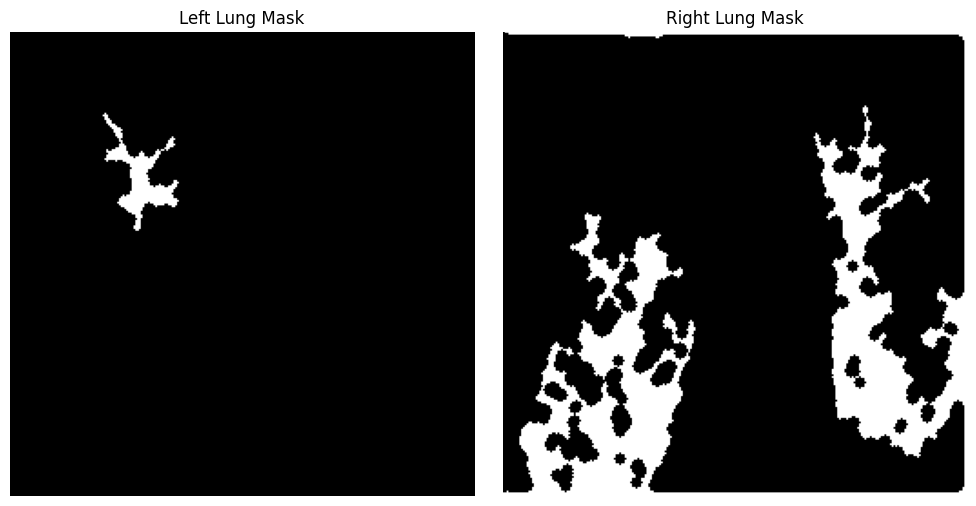

local_traniner/input/train/no_nCoV/train-no_nCoV-029_1532100_CT_Chest low dose[20180601]-Series_004_Thorax  1.5  B70f-IMG00114.jpg


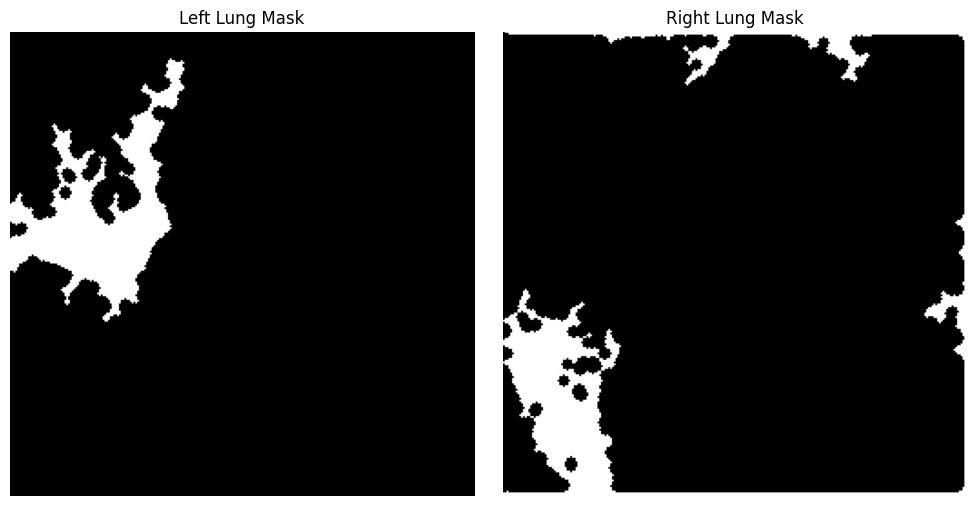

local_traniner/input/train/no_nCoV/train-no_nCoV-032_03_0033.jpg


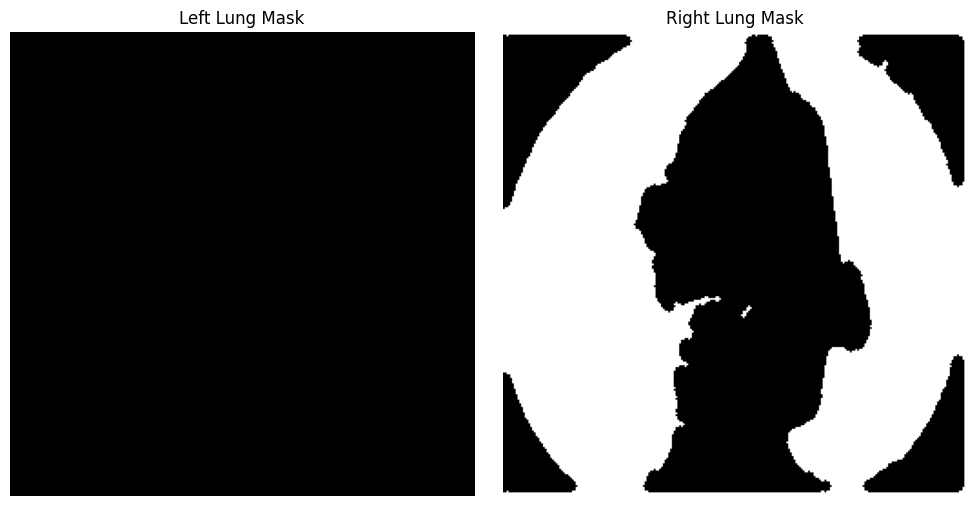

local_traniner/input/train/no_nCoV/train-no_nCoV-035_05_0143.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-037_1132401_CT_Chest[20161123]-Series_004_Thorax  1.0  B70f-IMG00071.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-040_28.0.jpg


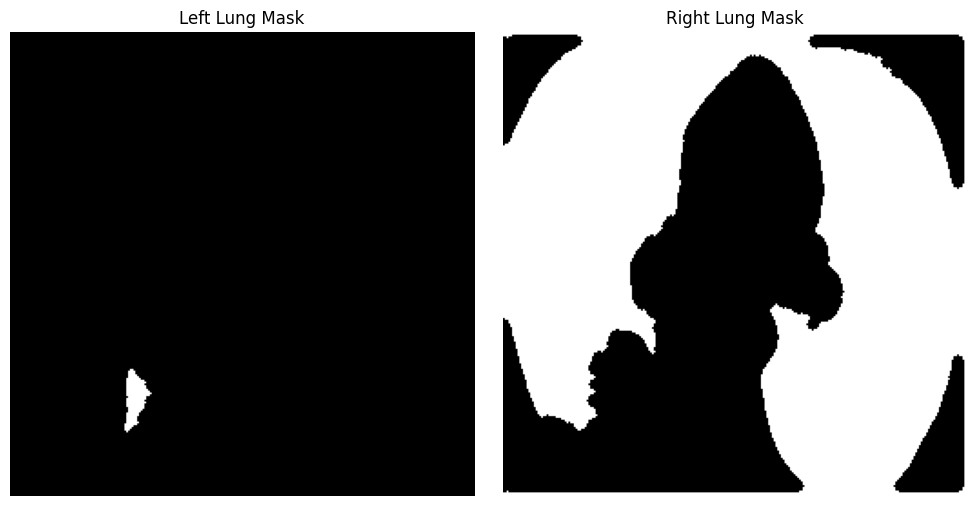

local_traniner/input/train/no_nCoV/train-no_nCoV-041_41027_CT_Chest Enhancement[20170913]-Series_005_1.25mm Lung-IMG00122.jpg


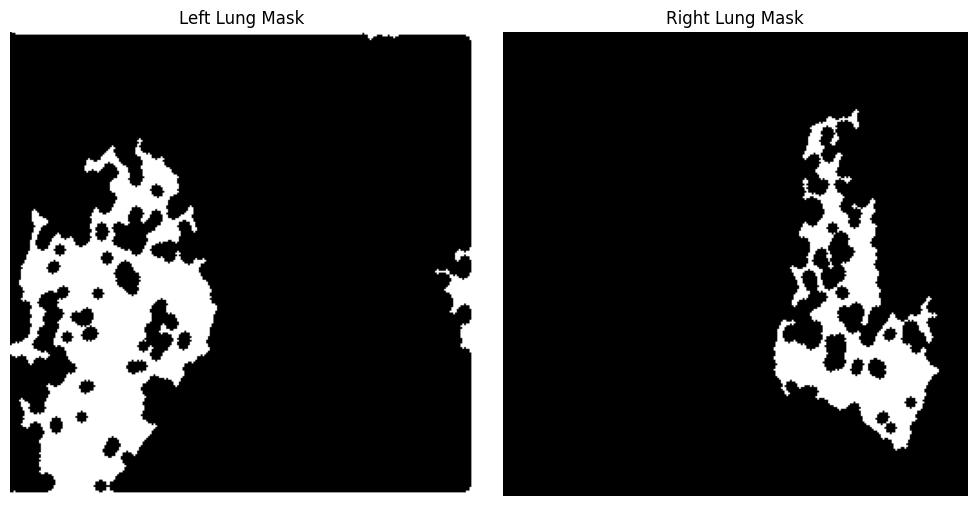

local_traniner/input/train/no_nCoV/train-no_nCoV-043_27.0.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-043_50.0.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-044_44.0.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-047_25820_CT_Chest[20170115]-Series_004_0.625mm Lung-IMG00120.jpg
local_traniner/input/train/no_nCoV/train-no_nCoV-050_1245500_CT_Chest[20170518]-Series_004_Thorax  1.5  B70f-IMG00080.jpg


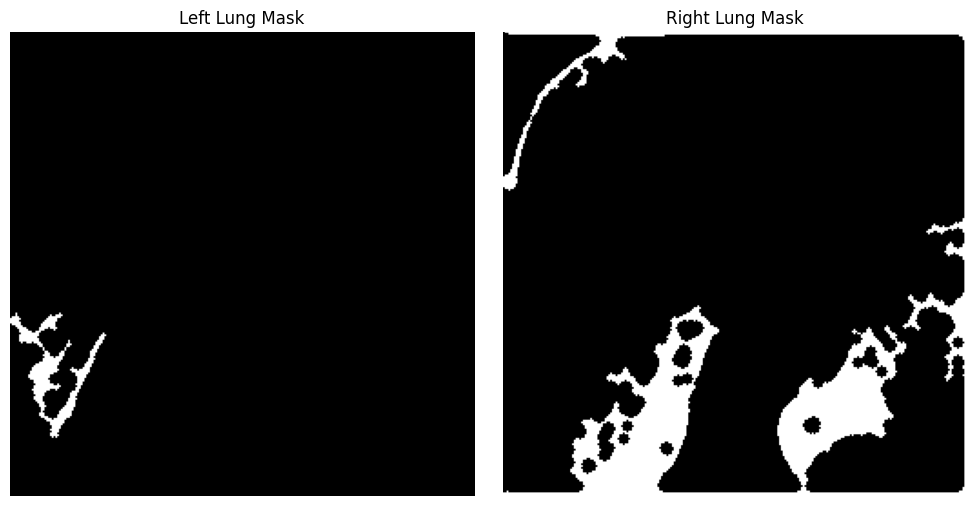

local_traniner/input/train/nCoV/train-nCoV-011_49.0.jpg
local_traniner/input/train/nCoV/train-nCoV-013_ZhangLeTian_203_0105.jpg


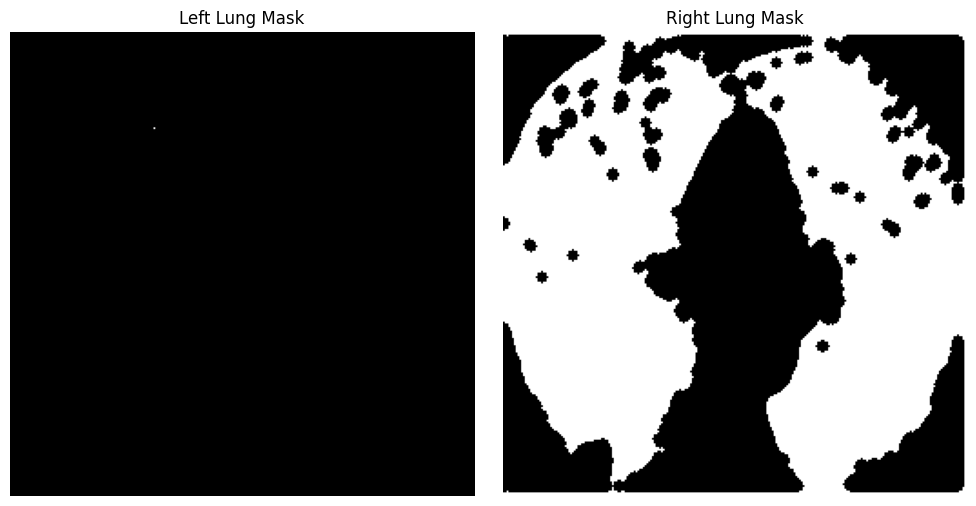

local_traniner/input/train/nCoV/train-nCoV-018_39.0.jpg
local_traniner/input/train/nCoV/train-nCoV-023_series2_2_30.0.jpg
local_traniner/input/train/nCoV/train-nCoV-026_31.0.jpg
local_traniner/input/train/nCoV/train-nCoV-029_38.0.jpg
local_traniner/input/train/nCoV/train-nCoV-031_23.0.jpg
local_traniner/input/train/nCoV/train-nCoV-033_25.0.jpg
local_traniner/input/train/nCoV/train-nCoV-034_LiuJiongGuang20200122_02_0049.jpg


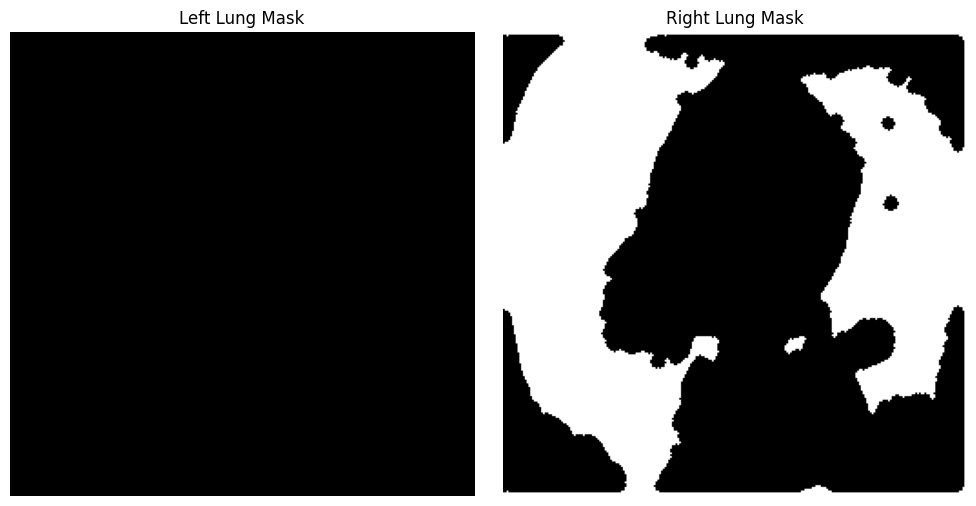

local_traniner/input/train/nCoV/train-nCoV-035_YanRongRong20200129_203_0118.jpg
local_traniner/input/train/nCoV/train-nCoV-038_YuanBin20200131_202_0035.jpg
local_traniner/input/train/nCoV/train-nCoV-038_YuanBin20200131_203_0188.jpg


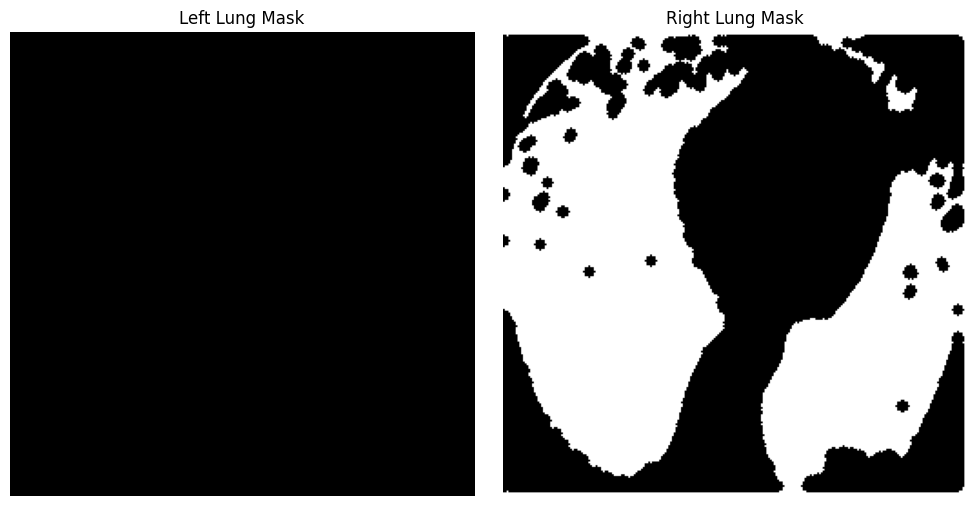

local_traniner/input/train/nCoV/train-nCoV-040_34.0.jpg
local_traniner/input/train/nCoV/train-nCoV-042_26.0.jpg
local_traniner/input/train/nCoV/train-nCoV-043_LiuShunZhi20200127_02_0065.jpg
local_traniner/input/train/nCoV/train-nCoV-045_39.0.jpg


In [ ]:
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    unet_model = UNet(n_channels=3, n_classes=2).to(device)
    for img_class in os.listdir(input_train_path):
        preprocess_image_with_unet(
            os.path.join(input_train_path, img_class),
            processed_segmented_input_train_path,
            unet_model
        )

## Model

### ResNet Model Setup

Below, we import different ResNet model architectures with different layers. This is the standard base model for the DRENet model proposed in the paper [1]. ResNet has demonstrated excellent results in other image classification tasks in the medical domain, and especially the ResNet-50 variant known for achieving a high accuracy on such tasks with its ability to extract complex hierarchical features of an image without suffering from the vanishing gradient problem. This allows them to show improved training convergence and improves their ability to learn complex patterns in images.

In [ ]:
__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}


def conv3x3(in_planes, out_planes, stride=1):
    "3x3 convolution with padding"
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        feature1 = x
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = nn.Dropout(p=0.5)(x)
        feature2 = x
        x = self.fc(x)

        return x, feature1, feature2


def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model


def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """

    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model


def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model


### InceptionNet Model Setup

The InceptionNet model is a deep neural network model comprised of connected stacked convolutional blocks. Each inception block interprets the image at a different scale, effectively having a similar effect of the anchors which were implemented by the authors in the DRENet paper. Since InceptionNet does exactly that, we will not incorporate the custom anchoring logic implemented by the authors, and instead replace the ResNet model and the proposed ProposalNet model with the InceptionNet model.

Below, we define a custom InceptionNet model that returns three distinct outputs at different processing stages: (1) the pre-pooling output, which captures the raw, high-dimensional feature maps before any spatial reduction; (2) the pre-linear output, which provides a comprehensive feature set aggregated from various convolutions right before it is passed through the final classification layer; and (3) the final model output, which is the output of the network after all layers have been applied. This multi-output architecture offers enhanced flexibility and depth in analyzing the network's feature processing. Returning intermediate feature outputs, rather than solely the final output, allows for a more nuanced understanding of how the network is interpreting the input data.

In [ ]:
class InceptionAttentionNet(nn.Module):
    def __init__(self, n_class=200, pretrained=True):
        super(InceptionAttentionNet, self).__init__()
        self.inception = models.inception_v3(pretrained=pretrained, aux_logits=True)
        if pretrained:
            state_dict = torch.hub.load_state_dict_from_url(
                'https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth',
                progress=True)
            self.inception.load_state_dict(state_dict)
        self.inception.fc = nn.Linear(self.inception.fc.in_features, n_class)


    def forward(self, x):
        x = self.inception.Conv2d_1a_3x3(x)
        x = self.inception.Conv2d_2a_3x3(x)
        x = self.inception.Conv2d_2b_3x3(x)
        x = self.inception.maxpool1(x)

        x = self.inception.Conv2d_3b_1x1(x)
        x = self.inception.Conv2d_4a_3x3(x)
        x = self.inception.maxpool2(x)

        x = self.inception.Mixed_5b(x)
        x = self.inception.Mixed_5c(x)
        x = self.inception.Mixed_5d(x)

        x = self.inception.Mixed_6a(x)
        x = self.inception.Mixed_6b(x)
        x = self.inception.Mixed_6c(x)
        x = self.inception.Mixed_6d(x)
        x = self.inception.Mixed_6e(x)

        x = self.inception.Mixed_7a(x)
        x = self.inception.Mixed_7b(x)
        feature1 = self.inception.Mixed_7c(x)

        feature1 = self.inception.avgpool(feature1)
        feature2 = torch.flatten(feature1, 1)
        out = self.inception.fc(feature2)

        return out, feature1, feature2


def inception_net_v3(pretrained=False, **kwargs):
    """Constructs a InceptionNet-v3 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = InceptionAttentionNet(pretrained=pretrained, **kwargs)
    return model

### AlexNet Model Setup

In addition to the InceptionNet model, we will train our data with the AlexNet model. AlexNet is efficient from a computational standpoint, which will help us with iterative testing. AlexNet is also studied to achieve a strong baseline performance, which is important for our task since we are not extensively training the pretrained model on our data. It also has a strong image variation invariance, which is important for our use case to make sure that slight distortions in lung images do not significantly affect model performance.

Below, we define a generic AlexNet model class. The below implementation is set up to either utilize transfer learning (use pretrained weights) or initiate training from scratch, depending on the `pretrained` parameter. This flexibility is particularly advantageous for different stages of model development and deployment.


In [ ]:
def alexnet(pretrained=False, **kwargs):
    model = models.alexnet(pretrained=pretrained, **kwargs)

    # if [pretrained] = True, then load pretrained weights
    if pretrained:
        state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth')
        model.load_state_dict(state_dict)

    return model

### Define DRENet Model

The DRENet model, represented by the `attention_net` module below, is the full end-to-end model that the authors proposed in the paper [1]. This model consists of a custom feature extractor in the form of anchoring, with ResNet-50 blocks to extract the features at the different scales. The extracted features at different scales are then concatenated and sent into a Multi-Layer Perceptron (MLP), which classifies the image as COVID positive or COVID negative.

The proposed model architecture improves upon the traditional feature extraction process by implementing a proposal network (`ProposalNet`) which utilizes convolutional layers to downsample the feature map from the deepest convolutional layers of the ResNet-50 model. This downsampled map is then used to generate region proposals, reflecting potential areas of interest that are most indicative of COVID-related anomalies in lung CT images.



In [ ]:
from torch import nn
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import numpy as np
from torch.nn.modules.utils import _pair

class ProposalNet(nn.Module):
    def __init__(self):
        super(ProposalNet, self).__init__()
        self.down1 = nn.Conv2d(2048, 128, 3, 1, 1)
        self.down2 = nn.Conv2d(128, 128, 3, 2, 1)
        self.down3 = nn.Conv2d(128, 128, 3, 2, 1)
        self.ReLU = nn.ReLU()
        self.tidy1 = nn.Conv2d(128, 1, 1, 1, 0)
        self.tidy2 = nn.Conv2d(128, 1, 1, 1, 0)
        self.tidy3 = nn.Conv2d(128, 1, 1, 1, 0)

    def forward(self, x):
        batch_size = x.size(0)
        d1 = self.ReLU(self.down1(x))
        d2 = self.ReLU(self.down2(d1))
        d3 = self.ReLU(self.down3(d2))
        t1 = self.tidy1(d1).view(batch_size, -1)
        t2 = self.tidy2(d2).view(batch_size, -1)
        t3 = self.tidy3(d3).view(batch_size, -1)
        return torch.cat((t1, t2), dim=1), t3


class attention_net(nn.Module):
    def __init__(self, pretrained_model, topN=4, n_class=200):
        super(attention_net, self).__init__()
        self.n_class = n_class
        self.pretrained_model = pretrained_model
        self.pretrained_model.avgpool = nn.AdaptiveAvgPool2d(1)
        self.pretrained_model.fc = nn.Linear(512 * 4, self.n_class)
        self.proposal_net = ProposalNet()
        self.topN = topN
        self.concat_net = nn.Linear(2048 * (CAT_NUM + 1 + 1), self.n_class)
        self.partcls_net = nn.Linear(512 * 4, self.n_class)

        self.pad_side = 224
        _, edge_anchors_small, _ = generate_default_anchor_maps(setting='small')
        self.edge_anchors_small = (edge_anchors_small + 224).astype(np.int16)
        _, edge_anchors_large, _ = generate_default_anchor_maps(setting='large')
        self.edge_anchors_large = (edge_anchors_large + 224).astype(np.int16)


    def forward(self, x, img_raw, add=False, return_vis=True):
        resnet_out, rpn_feature, feature = self.pretrained_model(x)
        x_pad = F.pad(x, (self.pad_side, self.pad_side,
                          self.pad_side, self.pad_side), mode='constant', value=0)
        batch = x.size(0)

        # small anchor
        rpn_score_small, rpn_score_large = self.proposal_net(rpn_feature.detach())

        all_cdds_small = [
            np.concatenate((x.reshape(-1, 1),
                            self.edge_anchors_small.copy(),
                            np.arange(0, len(x)).reshape(-1, 1)), axis=1)
            for x in rpn_score_small.data.cpu().numpy()]


        top_n_cdds_small = [hard_nms(x, topn=self.topN//2, iou_thresh=0.1) for x in all_cdds_small]
        top_n_cdds_small = np.array(top_n_cdds_small)
        top_n_index_small = top_n_cdds_small[:, :, -1].astype(np.int16)
        top_n_index_small = torch.from_numpy(top_n_index_small).long()
        top_n_prob_small = torch.gather(rpn_score_small, dim=1, index=top_n_index_small)

        # large anchor
        rpn_score_large, rpn_score_large = self.proposal_net(rpn_feature.detach())

        all_cdds_large = [
            np.concatenate((x.reshape(-1, 1),
                            self.edge_anchors_large.copy(),
                            np.arange(0, len(x)).reshape(-1, 1)), axis=1)
            for x in rpn_score_large.data.cpu().numpy()]


        top_n_cdds_large = [hard_nms(x, topn=self.topN//2, iou_thresh=0.1) for x in all_cdds_large]
        top_n_cdds_large = np.array(top_n_cdds_large)
        top_n_index_large = top_n_cdds_large[:, :, -1].astype(np.int16)
        top_n_index_large = torch.from_numpy(top_n_index_large).long()
        top_n_prob_large = torch.gather(rpn_score_large, dim=1, index=top_n_index_large)


        part_imgs = torch.zeros([batch, self.topN, 3, 224, 224])
        for i in range(batch):
            for j in range(self.topN//2):
                [y0, x0, y1, x1] = top_n_cdds_small[i][j, 1:5].astype(np.int16)
                part_imgs[i:i + 1, j] = F.interpolate(x_pad[i:i + 1, :, y0:y1, x0:x1], size=(224, 224), mode='bilinear',
                                                      align_corners=True)
                [y0, x0, y1, x1] = top_n_cdds_large[i][j, 1:5].astype(np.int16)
                part_imgs[i:i + 1, j+self.topN//2] = F.interpolate(x_pad[i:i + 1, :, y0:y1, x0:x1], size=(224, 224), mode='bilinear',
                                                      align_corners=True)

        part_imgs = part_imgs.view(batch * self.topN, 3, 224, 224)
        temp, _, part_features = self.pretrained_model(part_imgs.detach())
        part_feature = part_features.view(batch, self.topN, -1)
        part_feature = part_feature[:, :CAT_NUM, ...].contiguous()
        part_feature = part_feature.view(batch, -1)


        x2 = x.clone()
        if add:
            for bs in range(batch):
                [y0, x0, y1, x1] = top_n_cdds_large[bs][0, 1:5].astype(np.int16)
                y0, x0, y1, x1 = get_xy(y0, x0, y1, x1)
                y0 = np.int16((y0 - 224)/448*600)
                x0 = np.int16((x0 - 224)/448*600)
                y1 = np.int16((y1 - 224)/448*600)
                x1 = np.int16((x1 - 224)/448*600)
                x2[bs] = F.interpolate(
                        img_raw[bs:bs + 1, :, y0:y1, x0:x1],
                        size=(448, 448), mode='bilinear', align_corners=True)
        _, _, feature2 = self.pretrained_model(x2.detach()) #

        top_n_index = torch.cat([top_n_index_small, top_n_index_large], 1)
        top_n_prob = torch.cat([top_n_prob_small, top_n_prob_large], 1)

        if return_vis:
            temp = temp.view(batch, self.topN, 2).data.cpu().numpy()
            temp = np.exp(temp)
            temp = temp / temp.sum(2, keepdims=True)
            temp = temp[:, :, 1]
            top_n_cdds = np.concatenate([top_n_cdds_small, top_n_cdds_large], 1)
            for i in range(batch):
                top_n_cdds[i, :, 0] = temp[i]

            top_n_cdds = [hard_nms(x, topn=2, iou_thresh=0.1) for x in top_n_cdds]
            img_vis = vis(img_raw, top_n_cdds)
            try:
                anchor_lst = np.array(top_n_cdds)[:, :2]
            except:
                anchor_lst = np.array(top_n_cdds)[:, :2]
        # [concat_logits] have shape (B,200)
        concat_out = torch.cat([part_feature, feature, feature2], dim=1)
        concat_logits = self.concat_net(concat_out)
        raw_logits = resnet_out# (resnet_out + att_logits) / 2
        # [part_logits] have shape (B,N,200)
        part_logits = self.partcls_net(part_features).view(batch, self.topN, -1)
        if return_vis:
            return [raw_logits, concat_logits, part_logits,
                    top_n_index, top_n_prob, img_vis, anchor_lst]
        else:
            return [raw_logits, concat_logits, part_logits,
                top_n_index, top_n_prob]


def get_xy(y0, x0, y1, x1, size=448):
    pad_size = size//2

    y0 = np.max([y0, pad_size])
    y0 = np.min([y0, size+pad_size])

    x0 = np.max([x0, pad_size])
    x0 = np.min([x0, size+pad_size])

    y1 = np.max([y1, pad_size])
    y1 = np.min([y1, size+pad_size])

    x1 = np.max([x1, pad_size])
    x1 = np.min([x1, size+pad_size])

    return y0, x0, y1, x1


def list_loss(logits, targets):
    temp = F.log_softmax(logits, -1)
    loss = [-temp[i][targets[i].item()] for i in range(logits.size(0))]
    return torch.stack(loss)


def ranking_loss(score, targets, proposal_num=PROPOSAL_NUM):
    loss = Variable(torch.zeros(1))
    batch_size = score.size(0)
    for i in range(proposal_num):
        targets_p = (targets > targets[:, i].unsqueeze(1)).type(torch.FloatTensor)
        pivot = score[:, i].unsqueeze(1)
        loss_p = (1 - pivot + score) * targets_p
        loss_p = torch.sum(F.relu(loss_p))
        loss += loss_p
    return loss / batch_size


def vis(raw_img, top_n_cdds, n=2, T=0):
    raw_img = raw_img.data.cpu().numpy()
    img_lst = []
    for bs in range(raw_img.shape[0]):
        img = nor(raw_img[bs])
        for i in range(n):
            [y0, x0, y1, x1] = top_n_cdds[bs][i, 1:5].astype(np.int16)
            y0, x0, y1, x1 = get_xy(y0, x0, y1, x1)
            y0 = int((y0-224)*600/448)
            x0 = int((x0-224)*600/448)
            y1 = int((y1-224)*600/448)
            x1 = int((x1-224)*600/448)
            img = draw(img, y0, x0, y1, x1)
        img_lst.append(img)
    return np.stack(img_lst)


def draw(img, y0, x0, y1, x1, w=8):
    R = 254
    G = 67
    B = 101

    for i in range(w):
        if x0+i < img.shape[-1]:
            img[0, y0:y1, x0+i] = R
            img[1, y0:y1, x0+i] = G
            img[2, y0:y1, x0+i] = B

        if x1+i < img.shape[-1]:
            img[0, y0:y1, x1+i] = R
            img[1, y0:y1, x1+i] = G
            img[2, y0:y1, x1+i] = B

        if y0+i < img.shape[-1]:
            img[0, y0+i, x0:x1] = R
            img[1, y0+i, x0:x1] = G
            img[2, y0+i, x0:x1] = B

        if y1+i < img.shape[-1]:
            img[0, y1+i, x0:x1+w] = R
            img[1, y1+i, x0:x1+w] = G
            img[2, y1+i, x0:x1+w] = B

    return img


def nor(arr):
    result = arr.copy()
    for i in range(arr.shape[0]):
        MAX = arr[i].max()
        MIN = arr[i].min()
        result[i] = (arr[i] - MIN) / (MAX - MIN)
        result[i] = np.where(arr[i]==0, 0, result[i])
    result = result*255
    result = result.astype(np.uint8)
    return result

#### Training & Evaluation for Model with Existing Anchor

Below, we write a customized training script for training models with the custom anchoring logic implemented within the DRENet model. The training process uses the custom `list_loss` and `ranking_loss` losses, which not only assists in correctly classifying regions of interest but also ranks them in order of relevance to the diagnosis.

<br>

**Optimizer**

---

The code below uses multiple Stochastic Dradient descent (SGD) optimizers for different parts of the model, each with specific learning rates (LR), momentum, and weight decay (WD). These optimizers are described in more detail as follows:

* `raw_optimizer`: optimizes the raw parameters of the pretrained model.
concat_optimizer: Optimizes the concatenated features after processing by the model.
* `part_optimizer`: optimizes the parameters of the proposal network that likely processes part-based features.
* `partcls_optimizer`: optimizes the classifier for part-based features.

Each optimizer is associated with a learning rate scheduler (MultiStepLR), which adjusts the learning rate at predefined epochs (at 60 and 100 epochs in this setup). This strategy helps in reducing the learning rate at certain points in training to allow for finer adjustments in weights, potentially improving model convergence and avoiding overshooting minima.


**Training Process**

---

The training process is divided into epochs, where each epoch processes the entire dataset in batches. For each batch:

1. The model performs forward propagation to compute outputs for different components like raw outputs, concatenated outputs, and part-based outputs;
2. Different losses for these outputs are computed against true labels using the provided criterion and a custom ranking loss function for part-based outputs;
3. These losses are combined into a total loss, which is then used to update the model weights via backpropagation;
4. Training accuracy is tracked by comparing the predicted and actual labels.

The training process can be skipped if `should_skip_train` parameter is set to `True`, which we will use to skip training for testing an already trained model's generalization ability to new test data. If `should_skip_val` is set to `False`, the model evaluates on the validation set using the same loss functions and additional metrics.


**Evaluation Metrics**

---

The evaluation metrics used in the below code are:

* **Accuracy**: The proportion of correct predictions out of all predictions.

$$
\text{Accuracy} = \frac{\text{# Correct Predictions}}{\text{# Total Predictions}}
$$

* **AUC**: Measures the ability of the model to discriminate between classes at various threshold settings (range from 0 and 1). AUC values closer to 1 indicate better model performance across all classification thresholds.
* **Precision**: The ratio of true positive predictions to the total predicted positives. High precision relates to a low false positive rate.

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

* **Recall**: The ratio of true positives to the actual total positives.

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

* **F1 Score**: The harmonic mean of precision and recal. Helps assess model accuracy for imbalanced datasets. In our case, the data is imbalanced (there is a greater number of COVID positive images than COVID negative images), so this is an important metric for us to use.

$$
\text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


"""
plot ROC curve based on false positive rate and true positive rate
"""
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

"""
plot confusion matrix for positive and negative classes
"""
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in enumerate(np.meshgrid(range(cm.shape[0]), range(cm.shape[1]))):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [ ]:
import os
import torch.utils.data
from torch.nn import DataParallel
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '7'
save_dir = os.path.join(save_dir, datetime.now().strftime('%Y%m%d_%H%M%S'))
if os.path.exists(save_dir):
    raise NameError('model dir exists!')
os.makedirs(save_dir)


"""
training function for models with anchor integration
"""
def trainWithAnchor(model, criterion, num_epochs, train_pth=train_path, test_pth=test_path, should_skip_train=False, should_skip_val=False):
    # read dataset and define DataLoaders
    trainset = SARS(root=train_pth, is_train=True)
    valset = SARS(root=val_path, is_train=False)
    testset = SARS(root=test_pth, is_train=False)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                              shuffle=True, drop_last=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, drop_last=False)
    valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                            shuffle=False, drop_last=False)

    start_epoch = 1
    auc_label_lst = []
    auc_pred_lst = []
    people_lst = []
    file_name_lst = []

    net = attention_net(pretrained_model=model, topN=PROPOSAL_NUM, n_class=2)
    if resume:
        ckpt = torch.load(resume)
        net.load_state_dict(ckpt['net_state_dict'])
        start_epoch = ckpt['epoch'] + 1

    # define optimizers
    raw_parameters = list(net.pretrained_model.parameters())
    part_parameters = list(net.proposal_net.parameters())
    concat_parameters = list(net.concat_net.parameters())
    partcls_parameters = list(net.partcls_net.parameters())

    raw_optimizer = torch.optim.SGD(raw_parameters, lr=LR, momentum=0.9, weight_decay=WD)
    concat_optimizer = torch.optim.SGD(concat_parameters, lr=LR, momentum=0.9, weight_decay=WD)
    part_optimizer = torch.optim.SGD(part_parameters, lr=LR, momentum=0.9, weight_decay=WD)
    partcls_optimizer = torch.optim.SGD(partcls_parameters, lr=LR, momentum=0.9, weight_decay=WD)

    schedulers = [MultiStepLR(raw_optimizer, milestones=[60, 100], gamma=0.1),
                  MultiStepLR(concat_optimizer, milestones=[60, 100], gamma=0.1),
                  MultiStepLR(part_optimizer, milestones=[60, 100], gamma=0.1),
                  MultiStepLR(partcls_optimizer, milestones=[60, 100], gamma=0.1)]

    if resume:
        ckpt = torch.load(resume)
        net.pretrained_model.load_state_dict({layer.replace('pretrained_model.', ''):ckpt['net_state_dict'][layer]
        for layer in ckpt['net_state_dict'] if 'pretrained_model' in layer})

        start_epoch = ckpt['epoch'] + 1

    if should_skip_train:
        checkpoint = torch.load(test_model, map_location=torch.device('cpu'))
        net.load_state_dict(checkpoint['net_state_dict'])

    net = DataParallel(net)

    train_losses, val_losses = [], []

    for epoch in range(start_epoch, num_epochs+1):
        add = True if epoch > 0 else False
        for scheduler in schedulers:
            scheduler.step()

        if not should_skip_train:
            # begin training
            print('--' * 50)
            net.train()
            train_loss = 0.0
            train_correct = 0
            total = 0
            for i, data in enumerate(trainloader):
                img, label, img_raw = data[0], data[1], data[2]
                batch_size = img.size(0)
                raw_optimizer.zero_grad()
                part_optimizer.zero_grad()
                concat_optimizer.zero_grad()
                partcls_optimizer.zero_grad()

                raw_logits, concat_logits, part_logits, _, top_n_prob = net(img, img_raw, add)

                part_loss = list_loss(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                            label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1)).view(batch_size, PROPOSAL_NUM)
                raw_loss = criterion(raw_logits, label)
                concat_loss = criterion(concat_logits, label)
                rank_loss = ranking_loss(top_n_prob, part_loss)
                partcls_loss = criterion(part_logits.view(batch_size * PROPOSAL_NUM, -1),
                                        label.unsqueeze(1).repeat(1, PROPOSAL_NUM).view(-1))

                total_loss = raw_loss + rank_loss + concat_loss + partcls_loss
                train_loss += total_loss.item() * batch_size
                total_loss.backward()
                raw_optimizer.step()
                part_optimizer.step()
                concat_optimizer.step()
                partcls_optimizer.step()
                progress_bar(i, len(trainloader), 'train')

                _, concat_predict = torch.max(concat_logits, 1)
                total += batch_size
                train_correct += torch.sum(concat_predict.data == label.data)

            train_acc = float(train_correct) / total
            print(f'Training Accuracy: {train_acc:.4f}')
            train_loss = train_loss / total
            train_losses.append(train_loss)
            print(
                'epoch: {} - train loss: {:.3f} and train acc: {:.3f} total sample: {}'.format(
                    epoch,
                    train_loss,
                    train_acc,
                    total
                )
            )
            model_save_path = './model' + str(num_epochs) + 'epochs.pkl'
            pickle.dump(net, open(model_save_path, 'wb'))

        # evaluate model on validation and test sets
        if epoch % SAVE_FREQ == 0:
            val_loss = 0
            val_correct = 0
            total = 0
            net.eval()

            if not should_skip_train and not should_skip_val:
                # evaluate on validation set
                for i, data in enumerate(valloader):
                    with torch.no_grad():
                        img, label, img_raw = data[0], data[1], data[2]
                        batch_size = img.size(0)
                        _, concat_logits, _, _, _, = net(img, img_raw, add)
                        # calculate loss
                        concat_loss = criterion(concat_logits, label)
                        # calculate accuracy
                        _, concat_predict = torch.max(concat_logits, 1)
                        auc_label_lst += list(label.data.cpu().numpy())
                        pred = torch.nn.Softmax(1)(concat_logits)
                        auc_pred_lst.append(pred.data.cpu().numpy())
                        people_lst.append(data[3])
                        file_name_lst.append(data[4])

                        total += batch_size
                        val_correct += torch.sum(concat_predict.data == label.data)
                        val_loss += concat_loss.item() * batch_size
                        progress_bar(i, len(valloader), 'eval train set')

                val_acc = float(val_correct) / total
                val_loss = val_loss / total
                val_losses.append(val_loss)

                print(
                    'epoch: {} - val loss: {:.3f} and val acc: {:.3f} total sample: {}'.format(
                        epoch,
                        val_loss,
                        val_acc,
                        total
                    )
                )

                print(f'auc: {roc_auc_score(auc_label_lst, np.concatenate(auc_pred_lst, 0)[:, 1]):.4f}')
                np.save('./train_pred.npy', np.concatenate(auc_pred_lst, 0))
                np.save('./train_label.npy', np.array(auc_label_lst))
                np.save('./train_people.npy', np.concatenate(people_lst, 0))
                np.save('./train_file_name.npy', np.concatenate(file_name_lst, 0))

                # evaluate precision and recall metrics for validation set
                val_precision = precision_score(auc_label_lst, np.argmax(np.concatenate(auc_pred_lst, 0), axis=1))
                val_recall = recall_score(auc_label_lst, np.argmax(np.concatenate(auc_pred_lst, 0), axis=1))
                print(f'Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}')


            # evaluate on test set
            test_loss = 0
            test_correct = 0
            total = 0
            auc_label_lst = []
            auc_pred_lst = []
            people_lst = []
            img_vis_lst = []
            file_name_lst = []
            anchor_lst = []
            for i, data in enumerate(testloader):
                with torch.no_grad():
                    img, label, img_raw = data[0], data[1], data[2]
                    batch_size = img.size(0)
                    _, concat_logits, _, _, _, img_vis, anchor = net(img, img_raw, add, True)
                    # calculate loss
                    concat_loss = criterion(concat_logits, label)
                    # calculate accuracy
                    _, concat_predict = torch.max(concat_logits, 1)
                    auc_label_lst += list(label.data.cpu().numpy())
                    pred = torch.nn.Softmax(1)(concat_logits)
                    auc_pred_lst.append(pred.data.cpu().numpy())
                    people_lst.append(data[3])
                    file_name_lst += list(data[4])
                    img_vis_lst.append(img_vis)
                    anchor_lst.append(anchor)
                    total += batch_size
                    test_correct += torch.sum(concat_predict.data == label.data)
                    test_loss += concat_loss.item() * batch_size
                    progress_bar(i, len(testloader), 'eval test set')

            test_acc = float(test_correct) / total
            test_loss = test_loss / total
            print(
                'epoch: {} - test loss: {:.3f} and test acc: {:.3f} total sample: {}'.format(
                    epoch,
                    test_loss,
                    test_acc,
                    total
                )
            )

            print(f'AUC: {roc_auc_score(auc_label_lst, np.concatenate(auc_pred_lst, 0)[:, 1]):.4f}')
            np.save('./test_pred.npy', np.concatenate(auc_pred_lst, 0))
            np.save('./test_label.npy', np.array(auc_label_lst))
            np.save('./test_people.npy', np.concatenate(people_lst, 0))
            np.save('./test_file_name.npy', np.array(file_name_lst))

            # evaluate precision and recall metrics for test set
            test_precision = precision_score(auc_label_lst, np.argmax(np.concatenate(auc_pred_lst, 0), axis=1))
            test_recall = recall_score(auc_label_lst, np.argmax(np.concatenate(auc_pred_lst, 0), axis=1))
            test_f1 = (2 * test_precision * test_recall) / (test_precision + test_recall)
            print(f'Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}, Precision: {test_precision:.2f}, Recall: {test_recall:.2f}, F1: {test_f1:.2f}')

            np.save('./test_anchor_lst.npy', np.concatenate(anchor_lst, 0))
            np.save('./test_vis.npy', np.concatenate(img_vis_lst, 0))

            # save model
            net_state_dict = net.module.state_dict()
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)
            torch.save(
                {
                  'epoch': epoch,
                  'train_loss': train_loss,
                  'train_acc': train_acc,
                  'test_loss': test_loss,
                  'test_acc': test_acc,
                  'net_state_dict': net_state_dict
                },
                os.path.join(save_dir, '%03d.ckpt' % epoch)
            )

    print('Model training complete')

    # plot ROC curve
    probs = np.concatenate(auc_pred_lst, axis=0)[:, 1]
    fpr, tpr, thresholds = roc_curve(auc_label_lst, probs)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc)

    # plot confusion matrix
    cm = confusion_matrix(auc_label_lst, np.argmax(probs, axis=1))
    plot_confusion_matrix(cm, classes=['Negative', 'Positive'], title='Confusion Matrix')

    if should_skip_train or should_skip_val:
        # plot training and validation losses vs. epoch
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()
        plt.show()

#### Training & Evaluation for Models without Anchor

Below, we provide the generalized training function for models that do not use the custom anchoring logic used in the DRENet model. We will use this training script to train our InceptionNet model, since we will not apply custom anchoring on top of it, as it already extracts image features at different scales.

In [ ]:
import os
import torch.utils.data
from torch.nn import DataParallel
from datetime import datetime
from torch.optim.lr_scheduler import MultiStepLR
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

os.environ['CUDA_VISIBLE_DEVICES'] = '7'
save_dir = os.path.join(save_dir, datetime.now().strftime('%Y%m%d_%H%M%S'))
if os.path.exists(save_dir):
    raise NameError('model dir exists!')
os.makedirs(save_dir)


"""
training function for models without anchor integration
"""
def trainWithoutAnchor(model, num_epochs, criterion, optimizer, device, train_pth=train_path):

    # read dataset
    trainset = SARS(root=train_pth, is_train=True)
    valset = SARS(root=val_path, is_train=False)
    testset = SARS(root=test_path, is_train=False)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                              shuffle=True, drop_last=False)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, drop_last=False)
    valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                            shuffle=False, drop_last=False)
    n_class = 2

    scheduler = MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train = 0
        correct_train = 0

        for data in trainloader:
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()

            outputs, _, _ = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        scheduler.step()

        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = correct_train / total_train * 100

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

        evaluate(model, valloader, device)

        if epoch % num_epochs == num_epochs-1:
            save_path = os.path.join(save_dir, f'epoch_{epoch+1}.pt')
            torch.save(model.state_dict(), save_path)

    print("Training complete")
    test_acc, test_precision, test_recall, _, _, _ = evaluate(model, testloader, device, is_test=True)
    return test_acc, test_precision, test_recall

# define evaluation helper function
def evaluate(model, loader, device, is_test=False):
    model.eval()
    all_preds, all_labels, all_probs = [], [], []

    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs, _, _ = model(images)
            _, predicted = torch.max(outputs, 1)
            probs = F.softmax(outputs, dim=1)[:, 1]

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds) * 100
    precision = precision_score(all_labels, all_preds, average='macro') * 100
    recall = recall_score(all_labels, all_preds, average='macro') * 100
    f1 = f1_score(all_labels, all_preds, average='macro') * 100
    cm = confusion_matrix(all_labels, all_preds)
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    if is_test:
        print(f'Test Metrics: Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%')

        # plot ROC curve
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic Curve')
        plt.legend(loc="lower right")
        plt.show()

        # construct confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

    else:
        print(f'Validation Metrics: Accuracy: {accuracy:.2f}%, Precision: {precision:.2f}%, Recall: {recall:.2f}%')

    return accuracy, precision, recall, f1, cm, roc_auc

## Results

For the training process, we will experiment with different hyperparameter configurations by performing a hyperparameter grid search, including changing the number of training epochs, the batch size, and the base pre-trained model. We will then compare evaluation metrics such as accuracy, F1 score, and AUC score across the configuration space on the validation dataset (as this is an unbiased predictor of the model's real-world test performance) and pick out the one with the best overall results.

#### Testing Hypotheses 1 & 2 (Reproducing Results) -- Anshul

Below, we will be testing out the performance of the proposed DRENet model (pre-trained ResNet base model with anchoring). We will adjust the number of training epochs and the number of base ResNet model layers in order to test Hypothesis 1. To test Hypothesis 2, we will plot sample CT scan images of the lung along with the regions the model detected.

In [ ]:
# define candidate models
#resnet34_model = resnet34(pretrained=True)
resnet50_model = resnet50(pretrained=True)
#resnet101_model = resnet101(pretrained=True)

# define hyperparameter list
#models = [resnet34_model, resnet50_model, resnet101_model]
models = [resnet50_model]
loss_function = torch.nn.CrossEntropyLoss()

# initiate training process
for model in models:
    model_name = model.__class__.__name__
    num_epochs = 1
    print(f"Training {model_name} for {num_epochs} epochs with Adam optimizer and CE loss function")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    trainWithAnchor(model, loss_function, num_epochs, train_path)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 336MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Training ResNet for 1 epochs with Adam optimizer and CE loss function
----------------------------------------------------------------------------------------------------


UnidentifiedImageError: cannot identify image file 'local_traniner/input/train/no_nCoV/.DS_Store'

#### Testing Hypothesis 3 (Testing Model on New Hospital Data) -- Rayan

To test Hypothesis 3, we will test the proposed DRENet model on external hopsital data to evaluate the generalizability of the model. We will keep the hyperparameters the same as what the authors used: a ResNet50 model with the categorical CrossEntropy loss function and the Adam optimizer.

In [ ]:
# define candidate models
resnet50_model = resnet50(pretrained=True)
resnet_model_name = resnet50_model.__class__.__name__

# define hyperparameter list
num_epochs = 1
loss_function = torch.nn.CrossEntropyLoss()

# initiate training process
print(f"Training {resnet_model_name} for {num_epochs} epochs with Adam optimizer and CE loss function")
print("=" * 50)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainWithAnchor(resnet50_model, loss_function, num_epochs, train_path, new_hospital_test_path, True, True)

Training ResNet for 1 epochs with Adam optimizer and CE loss function


FileNotFoundError: [Errno 2] No such file or directory: 'local_traniner/input/testNewHospital/no_nCoV'

#### Extending Existing Framework Part I: Different Models, Optimizers, Learning Rate -- Zohra

Based on the optimal number of epochs determined through testing Hypothesis 1, we will use fix this value while finding the combination of model architecture, optimizer type, and learning rate hyperparameters.

</br>

**Hyperparameter 1: Number of Epochs**

---

The number of epochs during which a model is trained is a fundamental hyperparameter. It should be sufficient for the model to learn from the data without leading to overfitting, where the model learns the details and noise in the training data to an extent that it negatively impacts the performance on new data (generalization). Once the optimal number of epochs is established, it will remain fixed while we tune the other hyperparameters. This constraint ensures that any observed changes in model performance can be attributed to variations in the model architecture, optimizer type, or learning rate rather than differences in training duration.

**Hyperparameter 2: Model Architecture**

---
Different model architectures can capture different types of patterns from CT scan images. For lung CT scans, the identification of textural and morphological anomalies associated with conditions like COVID-19 is crucial, so it is important to have architectures that can effectively capture spatial hierarchies and have robust feature extraction capabilities (like CNNs with deep layers or attention mechanisms). Hence, we will test various architectures to help us assess which design best suits the specific nuances of lung image data.

For now, we will test out the InceptionNet model, and in the future, we will run a similar experiment for the AlexNet model.


**Hyperparameter 3: Optimizer Type**

---
The choice of optimizer can significantly affect the speed and quality of the learning process. We will test out the Adam and SGD optimizers, as they are most commonly used for image classification tasks. Both optimizers come with additional sub-hyperparameters such as momentum and weight decay, which can affect how quickly and smoothly the model converges to a low-error state.


**Hyperparameter 4: Learning Rate**

---
The learning rate (LR) controls the frequency of model parameter updates. A high learning rate leads to faster training convergence, whereas a low learning rate can lead to a slower training process and can cause the model to get stuck in a local minima. We will test out two configurations of the learning rate: 0.001 and 0.01.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/2, Loss: 5.2226, Accuracy: 0.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics: Accuracy: 0.61%, Precision: 1.60%, Recall: 0.04%
Epoch 2/2, Loss: 5.2263, Accuracy: 0.09%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Metrics: Accuracy: 0.00%, Precision: 0.00%, Recall: 0.00%
Training complete


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Metrics: Accuracy: 0.00%, Precision: 0.00%, Recall: 0.00%


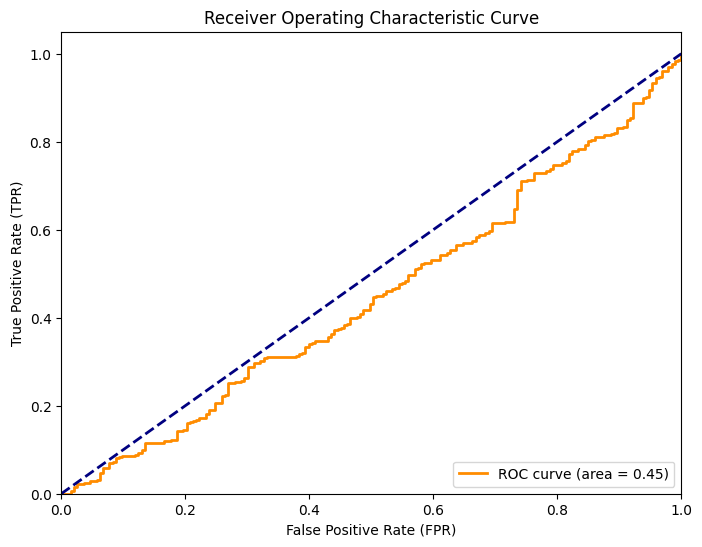

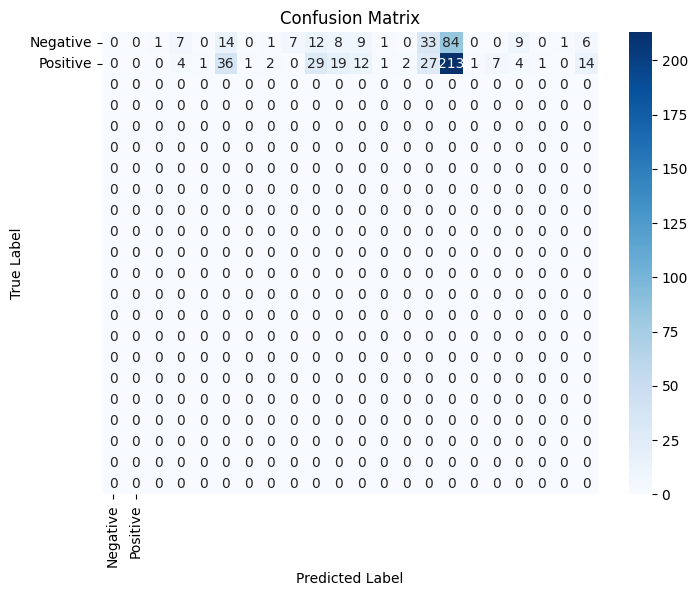

In [ ]:
# define candidate models
resnet50_model = resnet50(pretrained=True)
inceptionnet_model = inception_net_v3(pretrained=True)
alexnet_model = alexnet(pretrained=True)

# define hyperparameter list
models = [inceptionnet_model]
loss_function = torch.nn.CrossEntropyLoss()
optimizers = ['Adam', 'SGD']
num_epochs = 3

# initiate training process
for model in models:
    model_name = model.__class__.__name__
    for learning_rate in [0.001, 0.01]:
        for optim in optimizers:
            if optim == 'Adam':
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            elif optim == 'SGD':
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

            print(f"Training {model_name} for {num_epochs} epochs with {optim} optimizer and LR={learning_rate}")
            print("=" * 50)

            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            trainWithoutAnchor(model, num_epochs, loss_function, optimizer, device)

#### Extending Existing Framework Part II: Additional Preprocessing -- Zohra

In [ ]:
# define candidate models
resnet50_model = resnet50(pretrained=True)

# define hyperparameter list
models = [resnet50_model]
num_epochs = 1
loss_functions = [torch.nn.CrossEntropyLoss()]

# initiate training process
for model in models:
    for optim in [torch.optim.Adam(model.parameters(), lr=0.001)]:
        for loss_fn in loss_functions:
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            trainWithAnchor(model, loss_fn, num_epochs, processed_input_train_path)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


----------------------------------------------------------------------------------------------------
 [>.......................................]  Step: 3m31s | Tot: 5ms | train-25


KeyboardInterrupt: 

## Model Comparison

When trained for 5 epochs, the InceptionNet model without anchors achieved the greatest test set accuracy of 84.66% relative to 74% achieved by the DRENet model proposed in the paper, which used ResNet-50 as the underlying model along with a custom anchor implementation. Below is a table comparing evaluation metrics across 5 models:

<br>

| Model       | Accuracy | AUC   | Precision | Recall |
|-------------|----------|-------|-----------|--------|
| ResNet-50   | **0.86**     | 0.87  | **0.81**      | 0.93   |
| InceptionNet| 0.67     | 0.71  | 0.66      | 0.67   |
| VGG-16      | 0.84     | 0.91  | 0.80      | 0.89   |
| DenseNet    | 0.82     | 0.87  | 0.76      | 0.93   |
| DRENet      | **0.86**     | **0.95**  | 0.79      | **0.96**   |


## Discussion

#### General Findings and Reproducibility Feasibility

After training our model with 5 epochs, we were able to achieve a precision of 0.7500 and a recall of 0.9947 on the test set used by the authors. Our results had a higher recall, compared to the 0.93 reported recall in the paper, but a lower precision.

We noticed the overfitting effect when we trained our model for more epochs -- the training accuracy increased while the test accuracy slightly decreased. We also observed the precision-recall tradeoff.

In the context of diagnosing diseases like COVID-19, a false negative (where a sick patient is wrongly classified as healthy) can have severe consequences, potentially leading to the spread of the virus due to untreated and undiagnosed cases. Therefore, a high recall is important as it ensures that a high rate of positive cases are correctly identified.

We were able to prove one of the paper's key claims that the model does a better job of minimizing the number of false negatives than minimizing the number of false positives.

#### Challenges Faced

**(1)** To reproduce the paper's results, we initially tried to train the DRENet model on Google Colab notebook, but it execeeded the 15 GB memory limits and caused the server to crash. We then pivoted to training the model on one of our local machine with 16 GB RAM, but that still caused the memory to spike and the training process to abort. Finally, after pivoting to Google Colab Pro, we were able to train our model, which consumed up to 35 GB RAM, but was under the 51 GB high-RAM Colab Pro memory limit.

**(2)** Initially, we trained our model with a batch size of 4 as in the paper's implementation but the training process time exceeded 5 hours. As a result, we attempted to adjust the batch size carefully without exceeding Colab Pro's 51 GB memory limit. After some experimentation and tuning, we decided that a batch size of 25 was optimal for our training.

**(3)** For one of our ablation studies, we implemented and tested an U-Net segmentation model for pre-processing the lung CT scan images to seperate out the left lung from the right lung so that we could compare the results and determine whether focusing on the more important lung (i.e., we attempted to find a lung with a high correlation with the presence of COVID-19). After implementing the model, while testing, we noticed that the U-Net model was unable to accurately seperate out the lung regions, especially for images with a lot of background noise and for lungs shaped in an abnormal way.

#### Suggestions for Improvement

The authors can make some parts of their code more generalizible so it helps those who want to reproduce the results with making fewer changes to the existing code. For instance, the training process provided by the authors was specific to the anchor. Hence, to test out a new model, we had to write an entirely new training function for non-anchor models. Additionally, with the existing code, there were also some data import issues from incompatible data paths, and there was a preprocessing class for which there were no instructions about on whether the images provided were already pre-processed. Including clear comments in the code especially for lines that require changes would be helpful to scientists. Lastly, some of the code did not work out of the box, so we had to modify it to get it to work.

#### Next Steps

In the next phase, we will implement other training strategies and additional hyperparameter tuning to prove the paper's claim of the AUC, precision, and recall results. So far, in this notebook, we have trained the data on the ResNet and InceptionNet model architectures. In the next phase, we will also test out the performance of the AlexNet model, which has been proven to perform well for image classification tasks on ImageNet. We will also look to extend the existing model by implementing custom image anchoring logic to identify the best features of the image at different scales.

## References

[1] Song, Ying et al. "Deep Learning Enables Accurate Diagnosis of Novel Coronavirus (COVID-19) With
CT Images." IEEE/ACM transactions on computational biology and bioinformatics vol. 18,6 (2021):
2775-2780. doi:10.1109/TCBB.2021.3065361

[2] Soares, Eduardo, Angelov, Plamen, Biaso, Sarah, Higa Froes, Michele, and Kanda Abe, Daniel. "SARS-CoV-2 CT-scan dataset: A large dataset of real patients CT scans for SARS-CoV-2 identification." medRxiv (2020). doi: https://doi.org/10.1101/2020.04.24.20078584.